In [1]:

!pip install -q "timm==0.6.13"

import timm, sys
print("timm:", timm.__version__)
print(">> Now go to Runtime → Restart runtime, then re-run from the top.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 7.6 MB/s eta 0:00:00
timm: 0.6.13
>> Now go to Runtime → Restart runtime, then re-run from the top.


In [2]:

!pip install --quiet ultralytics==8.3.39 opencv-python-headless==4.10.0.84 timm==0.9.16


try:
    import torch, torchvision, torchaudio
    print("Using preinstalled torch:", torch.__version__)
except Exception:
    !pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    print("Installed torch:", torch.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.4 MB/s eta 0:00:00
Using preinstalled torch: 2.9.0+cu126


In [3]:
import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO


np.random.seed(42)
torch.manual_seed(42)

DATA = Path("data/images")
OUT  = Path("outputs")
(OUT / "overlays").mkdir(parents=True, exist_ok=True)
(OUT / "depth").mkdir(parents=True, exist_ok=True)

images = sorted(glob.glob(str(DATA / "*.*")))
print(f"Found {len(images)} images:", [Path(p).name for p in images])


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Found 0 images: []


In [4]:
def overlay_masks(image_bgr, masks, labels, scores, alpha=0.35):
    out = image_bgr.copy()
    h, w = out.shape[:2]
    color_cache = {}
    for i, m in enumerate(masks):
        cls = labels[i]; score = scores[i]
        color_cache.setdefault(cls, tuple(np.random.randint(0,255,3).tolist()))
        color = color_cache[cls]
        if m.shape[-2:] != (h, w):
            m = cv2.resize(m.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
        layer = np.zeros_like(out, dtype=np.uint8)
        layer[m > 0] = color
        out = cv2.addWeighted(out, 1.0, layer, alpha, 0)
        pts = np.argwhere(m > 0)
        if pts.size:
            y, x = pts[np.random.randint(0, len(pts))]
            cv2.putText(out, f"{cls} {score:.2f}", (int(x), int(y)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    return out

def save_fig(img_bgr, path, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis("off"); plt.tight_layout(); plt.savefig(path, dpi=200); plt.close()

def normalize01(x):
    x = x.astype(np.float32); x -= x.min()
    return x / (x.max() - x.min() + 1e-6)


In [5]:

model = YOLO("yolov8n-seg.pt")
model.fuse()

print("YOLO loaded and fused.")

FOODISH = {
    "banana","apple","orange","broccoli","carrot","pizza","donut","cake",
    "hot dog","sandwich","bowl","cup","bottle","wine glass","fork","knife","spoon"
}

for img_path in images:
    img = cv2.imread(img_path)
    if img is None:
        print("Failed to read:", img_path)
        continue

    # use 'model', not 'yolo'
    res = model.predict(source=img_path, imgsz=640, conf=0.25, verbose=False)[0]

    masks, labels, scores = [], [], []
    if res.masks is not None and res.boxes is not None:
        names = res.names
        for i in range(len(res.boxes)):
            cls_id = int(res.boxes.cls[i].item())
            name   = names.get(cls_id, str(cls_id))
            score  = float(res.boxes.conf[i].item())
            if name in FOODISH and score >= 0.25:
                m = res.masks.data[i].cpu().numpy().astype(np.uint8)
                m = cv2.resize(m, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
                masks.append(m); labels.append(name); scores.append(score)

    overlay = overlay_masks(img, masks, labels, scores) if masks else img.copy()
    if not masks:
        cv2.putText(overlay, "No 'food-ish' detections", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 2, cv2.LINE_AA)

    out_path = OUT / "overlays" / (Path(img_path).stem + "_overlay.png")
    save_fig(overlay, out_path, title="YOLOv8n-seg")
    print("Saved:", out_path)


100%|██████████| 6.74M/6.74M [00:00<00:00, 27.4MB/s]


YOLOv8n-seg summary (fused): 195 layers, 3,404,320 parameters, 0 gradients, 12.0 GFLOPs
YOLO loaded and fused.


In [ ]:
# MiDaS depth with safe shape handling (works for DPT_Hybrid or MiDaS_small)
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def normalize01(x):
    x = x.astype(np.float32); x -= x.min()
    return x / (x.max() - x.min() + 1e-6)

def run_depth(model_name="DPT_Hybrid", transform_name="dpt_transform"):
    m = torch.hub.load("intel-isl/MiDaS", model_name)
    t = torch.hub.load("intel-isl/MiDaS", "transforms")
    transform = getattr(t, transform_name)
    m.eval().to("cpu")
    print(f"Loaded {model_name} with {transform_name}")

    maps = {}
    for img_path in images:
        bgr = cv2.imread(img_path)
        if bgr is None:
            print("Failed:", img_path);
            continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        # transform can return [3,H,W] or [1,3,H,W];
        inp = transform(rgb)
        if inp.ndim == 3:           # [3,H,W] -> add batch
            inp_b = inp.unsqueeze(0)
        elif inp.ndim == 4:         # already [1,3,H,W]
            inp_b = inp
        else:
            raise ValueError(f"Unexpected input dims {inp.shape}")

        with torch.no_grad():
            pred = m(inp_b)         # usually [1,H,W]
            if pred.ndim == 3:      # [1,H,W] -> add channel dim
                pred = pred.unsqueeze(1)
            elif pred.ndim == 4:    # already [1,1,H,W]
                pass
            else:
                raise ValueError(f"Unexpected pred dims {pred.shape}")

            pred = torch.nn.functional.interpolate(
                pred, size=rgb.shape[:2], mode="bicubic", align_corners=False
            ).squeeze().cpu().numpy()   # -> [H,W]

        depth = normalize01(pred); maps[img_path] = depth
        depth_vis = (plt.cm.viridis(depth)[:, :, :3] * 255).astype(np.uint8)
        out_path = OUT / "depth" / (Path(img_path).stem + "_depth.png")
        plt.figure(figsize=(6,6)); plt.imshow(depth_vis); plt.axis("off")
        plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()
        print("Saved:", out_path)
    return maps


try:
    depth_maps = run_depth("DPT_Hybrid", "dpt_transform")
except Exception as e:
    print("DPT_Hybrid failed → falling back to MiDaS_small:", e)
    depth_maps = run_depth("MiDaS_small", "small_transform")


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


  0%|          | 256k/470M [00:00<04:44, 1.73MB/s]

In [ ]:
!pip -q install "timm==0.6.13"
import timm; print("timm:", timm.__version__)


timm: 0.9.16


In [ ]:

import pandas as pd
from pathlib import Path

DENSITY = {
    "pizza":1.8,"sandwich":1.7,"hot dog":1.6,"donut":1.2,"cake":1.3,
    "banana":1.0,"apple":1.0,"orange":1.0,"broccoli":0.9,"carrot":0.9,
    "bowl":1.2,"cup":1.2,"bottle":1.2,"wine glass":1.2,"_default":1.0
}
KCAL_PER_G = {
    "pizza":2.5,"sandwich":2.3,"hot dog":2.7,"donut":3.9,"cake":3.8,
    "banana":0.9,"apple":0.5,"orange":0.5,"broccoli":0.35,"carrot":0.41,
    "_default":1.5
}

rows = []
for img_path in images:
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    res = model.predict(source=img_path, imgsz=640, conf=0.25, verbose=False)[0]
    names = res.names
    if res.masks is None or res.boxes is None:
        continue

    depth = depth_maps.get(img_path)
    if depth is None:
        continue

    for i in range(len(res.boxes)):
        cls_id = int(res.boxes.cls[i].item())
        name   = names.get(cls_id, str(cls_id))
        score  = float(res.boxes.conf[i].item())
        if name not in FOODISH or score < 0.25:
            continue

        m = res.masks.data[i].cpu().numpy().astype(np.uint8)
        m = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)

        area = int(m.sum())
        if area == 0:
            continue

        mean_depth = float(depth[m > 0].mean())
        proxy_norm = (mean_depth * area) / float(h * w)

        grams = DENSITY.get(name, DENSITY["_default"]) * proxy_norm * 1000.0
        kcal  = grams * KCAL_PER_G.get(name, KCAL_PER_G["_default"])

        rows.append({
            "image": Path(img_path).stem,
            "class": name,
            "score": round(score, 3),
            "area_px": area,
            "mean_depth": round(mean_depth, 4),
            "proxy_norm": round(proxy_norm, 6),
            "grams_est": round(grams, 1),
            "kcal_est": round(kcal, 1),
        })

df = pd.DataFrame(rows).sort_values(["image","kcal_est"], ascending=[True, False])
csv_path = OUT / "initial_estimates.csv"
df.to_csv(csv_path, index=False)
print("Saved CSV:", csv_path)
df.head(20)


Saved CSV: outputs/initial_estimates.csv


,image,class,score,area_px,mean_depth,proxy_norm,grams_est,kcal_est
5,image2,orange,0.329,155611,0.8904,0.039111,39.1,19.6
0,image2,orange,0.834,125603,0.7923,0.028088,28.1,14.0
1,image2,orange,0.825,80293,0.6975,0.015808,15.8,7.9
3,image2,orange,0.401,57687,0.7475,0.012171,12.2,6.1
2,image2,broccoli,0.580,58121,0.6590,0.010811,9.7,3.4
4,image2,orange,0.349,30444,0.6641,0.005707,5.7,2.9
7,image2,orange,0.258,22455,0.7387,0.004682,4.7,2.3
6,image2,carrot,0.301,21888,0.7638,0.004719,4.2,1.7
11,image3,bowl,0.594,2421707,0.7134,0.140921,169.1,253.7
8,image3,fork,0.824,134702,0.6386,0.007017,7.0,10.5


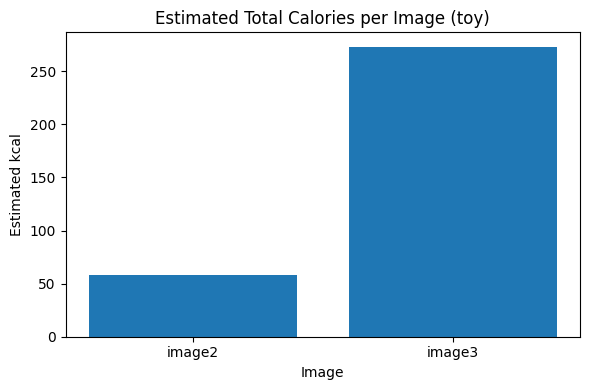

,image,kcal_est
0,image2,57.9
1,image3,273.0


In [ ]:

import matplotlib.pyplot as plt

if len(df):
    totals = df.groupby("image")["kcal_est"].sum().reset_index()
    plt.figure(figsize=(6,4))
    plt.bar(totals["image"], totals["kcal_est"])
    plt.title("Estimated Total Calories per Image (toy)")
    plt.xlabel("Image"); plt.ylabel("Estimated kcal")
    plt.tight_layout(); plt.show()
    display(totals)
else:
    print("No estimates produced — check detections or earlier cells.")
